In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 18, 'text.usetex': True})

In [2]:
# Load CVDV library (reload if already loaded)
import sys
import importlib
if 'interface' in sys.modules:
    importlib.reload(sys.modules['interface'])
from interface import CVDV

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled successfully!
Library loaded successfully!
Debug logs are written to: /home/luxi/cuda-cvdv/cuda.log
NOTE: Log file is cleared each time CVDV() is instantiated


---
# Part 1: Single Register Tests

Test operations on a single register with large dimension.

In [3]:
# Simulation parameters for single register tests
CV_LEVEL = 12      # 2^12 = 4096 grid points
WIGNER_N = 201     # Wigner function grid size
WIGNER_MAX = 5.0   # Wigner function range
PLOT_X_RANGE = 6   # x-axis range for plots

## Test 1: Vacuum State

Number of registers: 1Initialized state with 1 registers, total size: 4096

Total state size: 4096 elements (0.000 GB in VRAM)
  Register 0: dim=4096, qubits=12, dx=0.039166, x_bound=160.424210


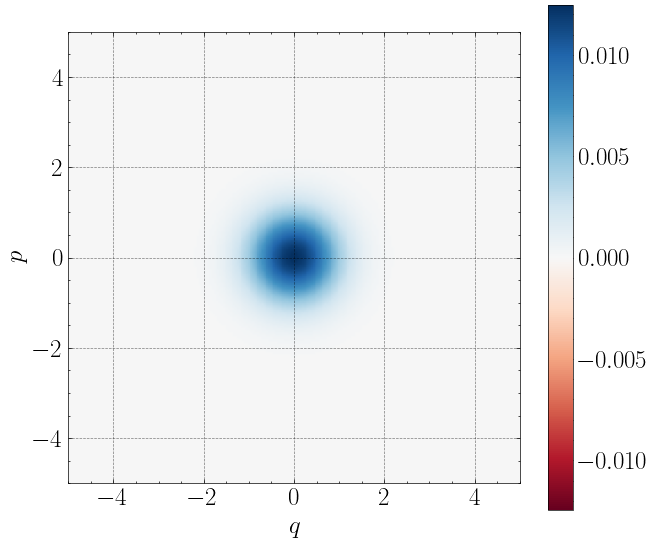

In [4]:
# Initialize single register system
# Register with 2^12 = 4096 points, dx automatically calculated
sim = CVDV([CV_LEVEL])

# Initialize to vacuum state
sim.setFock(0, 0)
sim.initStateVector()  # Build tensor product and upload to device

# Print system info
sim.info()

def debugPlot():
    wigner_complex = sim.getWignerSingleSlice(0, [ -1 ], wignerN=WIGNER_N, wXMax=WIGNER_MAX, wPMax=WIGNER_MAX)

    fig, ax = plt.subplots(figsize=(7, 6))
    vmax = np.max(np.abs(wigner_complex))
    im = ax.imshow(wigner_complex, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$p$')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
debugPlot()

## Test 2: Displacement Operator

Test D(α) with different displacement parameters.

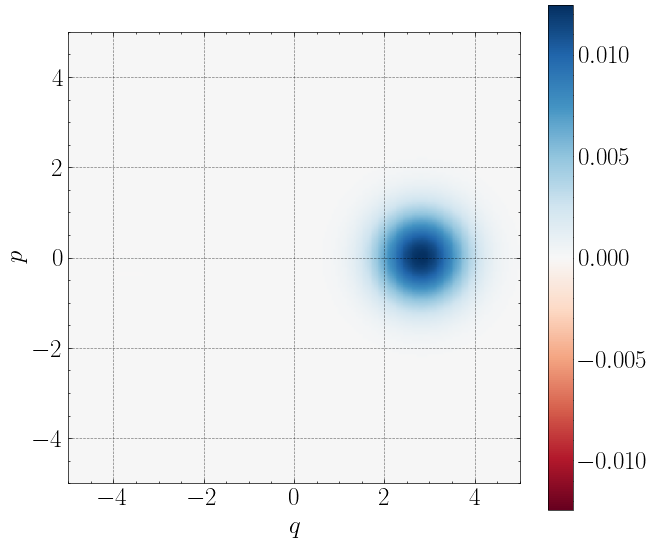

In [5]:
# Test with real displacement
sim.setFock(0, 0)  # Reset to vacuum
sim.displacement(0, 2)
debugPlot()

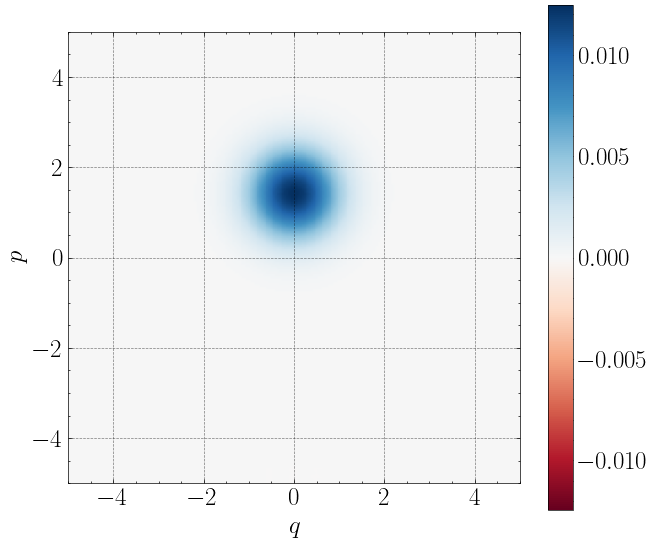

In [6]:
# Test with complex displacement
sim.displacement(0, -2 + 1.0j)
debugPlot()

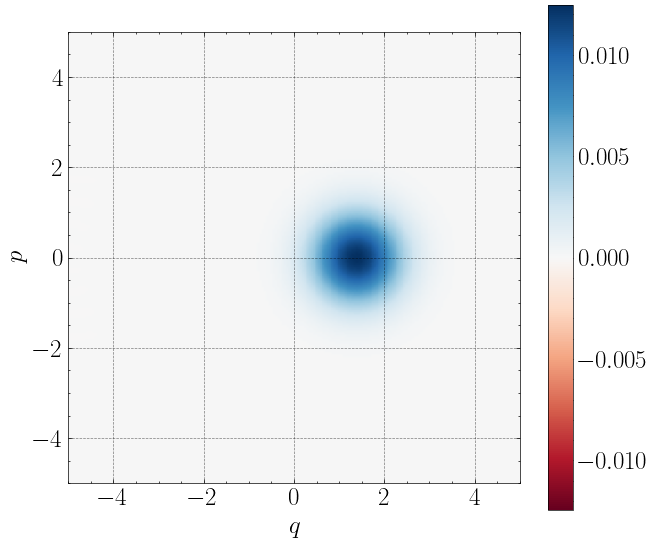

In [7]:
sim.ftQ2P(0)  # Fourier transform to momentum basis
debugPlot()

In [8]:
del sim

---
# Part 2: Multi-Register Tests

Test conditional displacement with 2 registers of different dimensions.

In [9]:
DV_QUBITS = 1
CV_LEVEL_HYBRID = 10
sim = CVDV([DV_QUBITS, CV_LEVEL_HYBRID])

# Initialize: |0⟩ ⊗ |vac⟩
sim.setZero(0)  # Register 0 to |0⟩
sim.setFock(1, 0)  # Register 1 to vacuum
sim.initStateVector()  # Build tensor product and upload to device

sim.info()
def debugPlot():
    # Compute Wigner functions for each qubit basis state
    # For register 1 when register 0 is in |0⟩ or |1⟩
    wigner_0 = sim.getWignerSingleSlice(1, [0, -1], wignerN=WIGNER_N, 
                                        wXMax=WIGNER_MAX, wPMax=WIGNER_MAX)
    wigner_1 = sim.getWignerSingleSlice(1, [1, -1], wignerN=WIGNER_N,
                                        wXMax=WIGNER_MAX, wPMax=WIGNER_MAX)

    # Verify probabilities using new API
    probs = sim.measure(0)
    print(f"Register 0 probabilities: {probs}")
    print(f"P(qubit=|0⟩) = {probs[0]:.6f}")
    print(f"P(qubit=|1⟩) = {probs[1]:.6f}")
    print(f"Sum = {probs.sum():.6f} (should be 1.0)")

    # Plot both Wigner functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # |0⟩ component (displaced by +α)
    vmax = np.max(np.abs(wigner_0))
    im1 = ax1.imshow(wigner_0, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                    origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
    ax1.set_xlabel(r'$q$')
    ax1.set_ylabel(r'$p$')
    ax1.set_title(r'$|0\rangle \otimes ?$')
    plt.colorbar(im1, ax=ax1)

    # |1⟩ component (displaced by -α)
    vmax = np.max(np.abs(wigner_1))
    im2 = ax2.imshow(wigner_1, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                    origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
    ax2.set_xlabel(r'$q$')
    ax2.set_ylabel(r'$p$')
    ax2.set_title(r'$|1\rangle \otimes ?$')
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()


Number of registers: 2Initialized state with 2 registers, total size: 2048

Total state size: 2048 elements (0.000 GB in VRAM)
  Register 0: dim=2, qubits=1, dx=1.772454, x_bound=3.544908
  Register 1: dim=1024, qubits=10, dx=0.078332, x_bound=80.212105


## Test: Conditional Displacement CD(α)

Prepare |+⟩ ⊗ |vac⟩ and apply CD(α):
- CD(α)|+⟩|vac⟩ = (|0⟩|+α⟩ + |1⟩|-α⟩)/√2

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


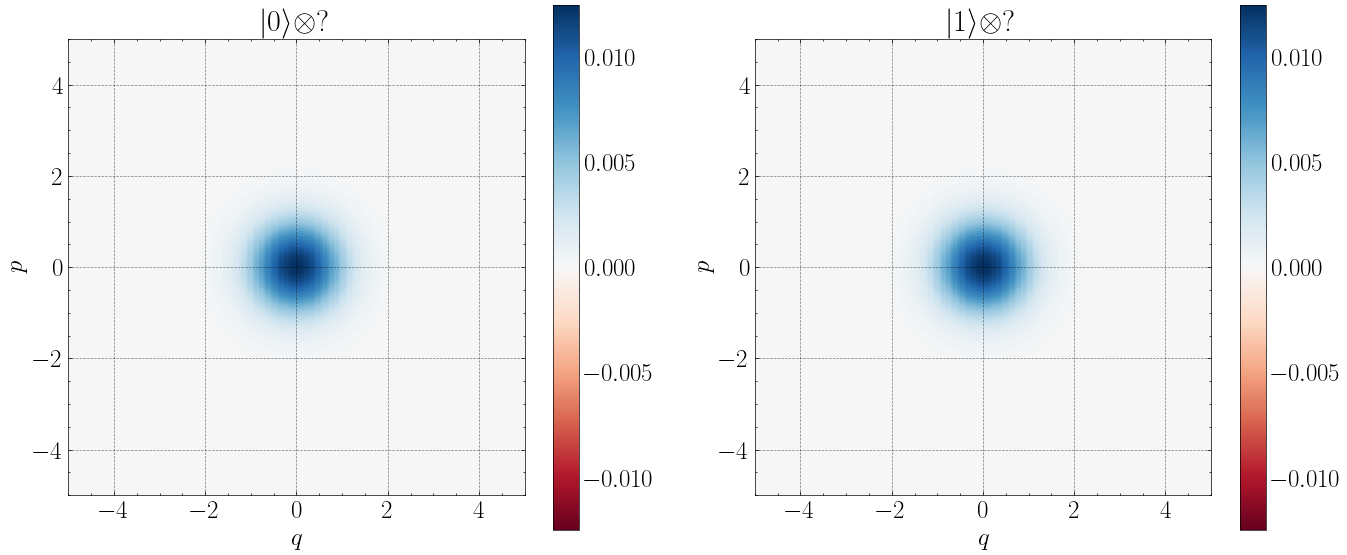

In [10]:
# Prepare |+⟩ = (|0⟩ + |1⟩)/√2
sim.hadamard(0, 0)  # Hadamard on qubit 0 of register 0
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


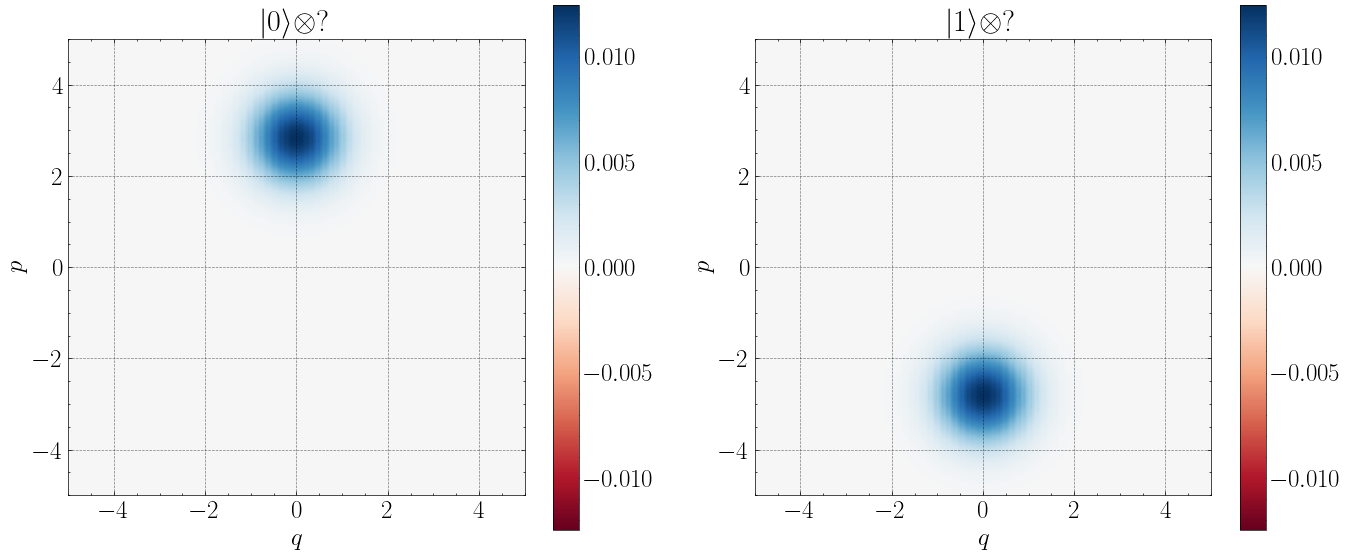

In [11]:
# Apply conditional displacement
alpha_cd = 2.0j
sim.cd(targetReg=1, ctrlReg=0, ctrlQubit=0, alpha=alpha_cd)
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


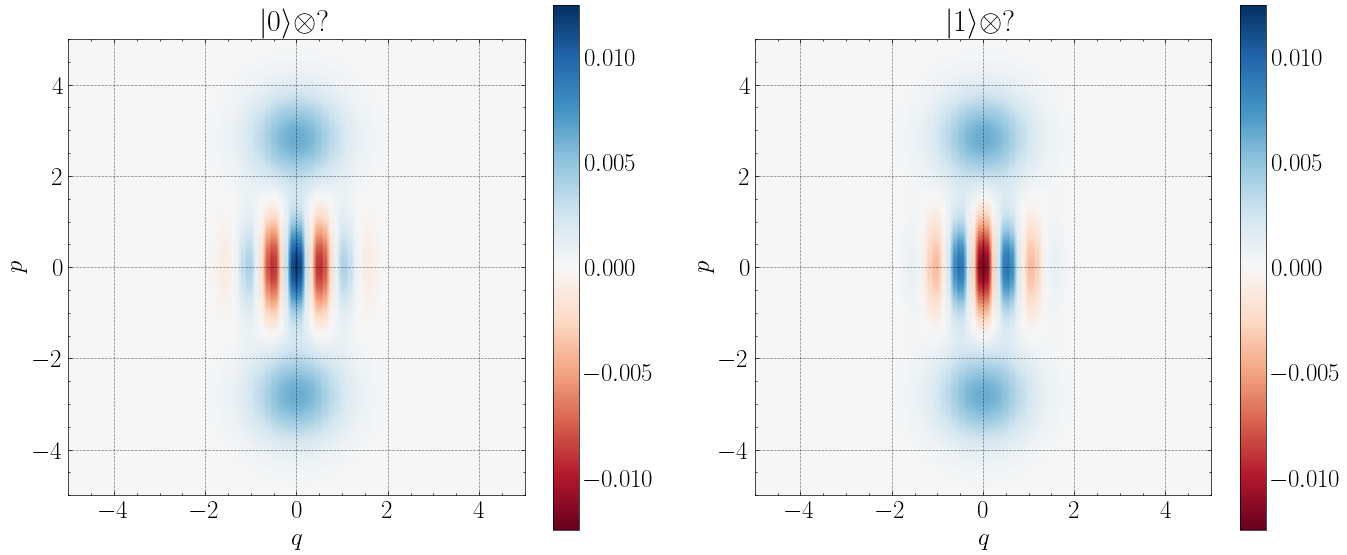

In [12]:
# Apply Hadamard again to complete entangling operation
sim.hadamard(0, 0)
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


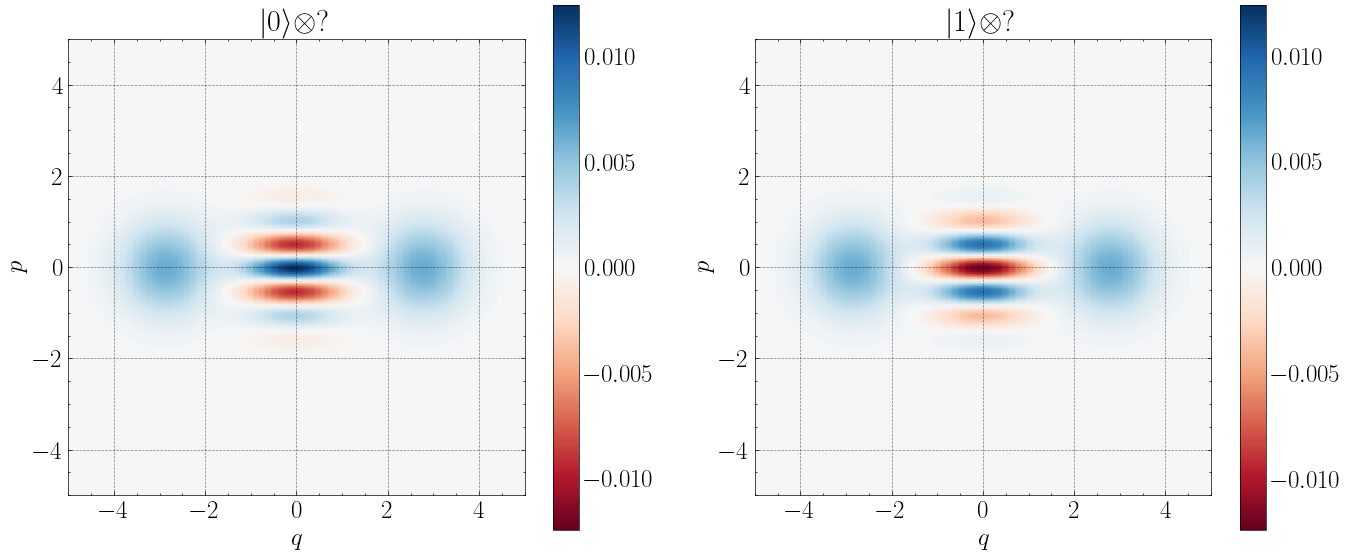

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


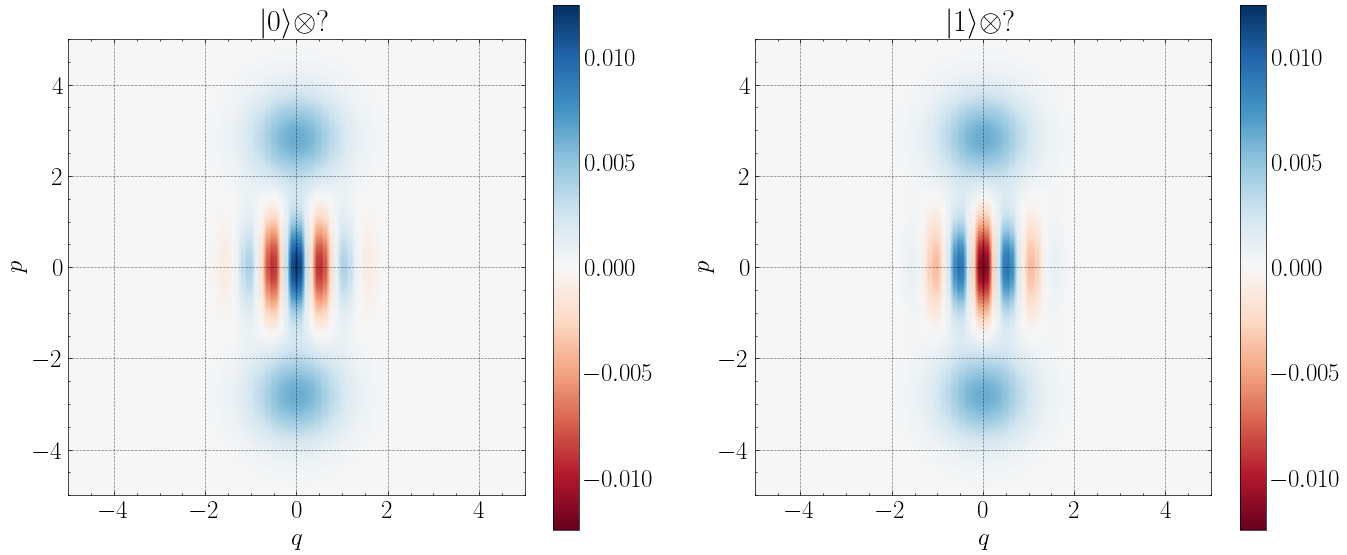

In [13]:
# Test Fourier Transform
sim.ftQ2P(1)
debugPlot()
sim.ftP2Q(1)
debugPlot()

In [14]:
# # Testing phase square gate
# sim.phaseSquare(1, 0.5)
# debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


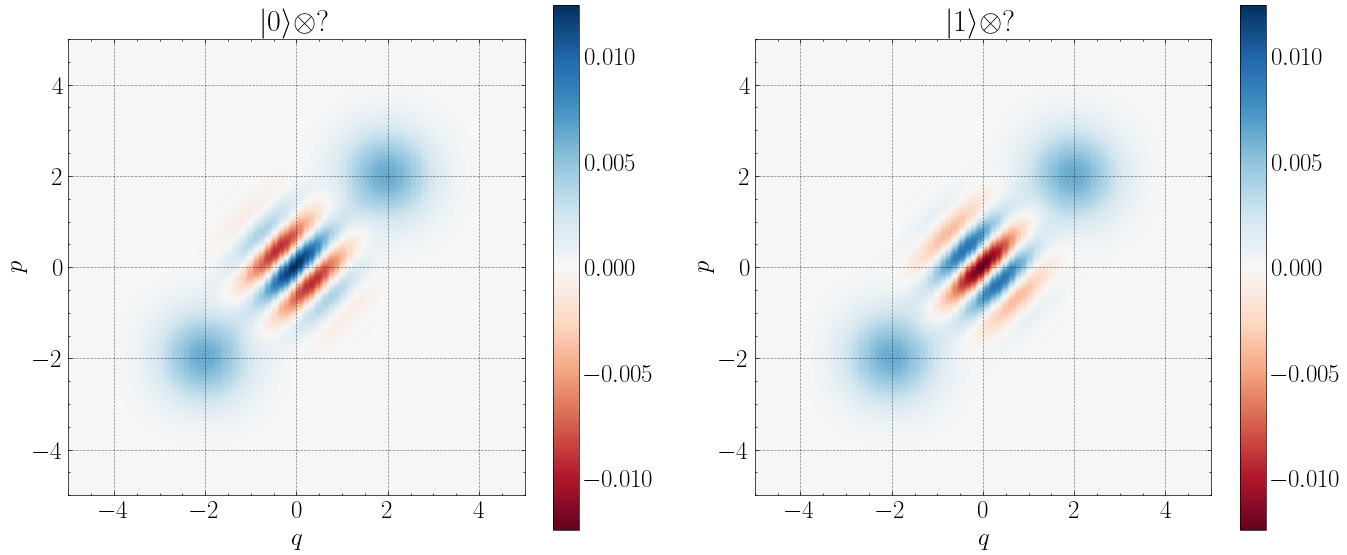

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


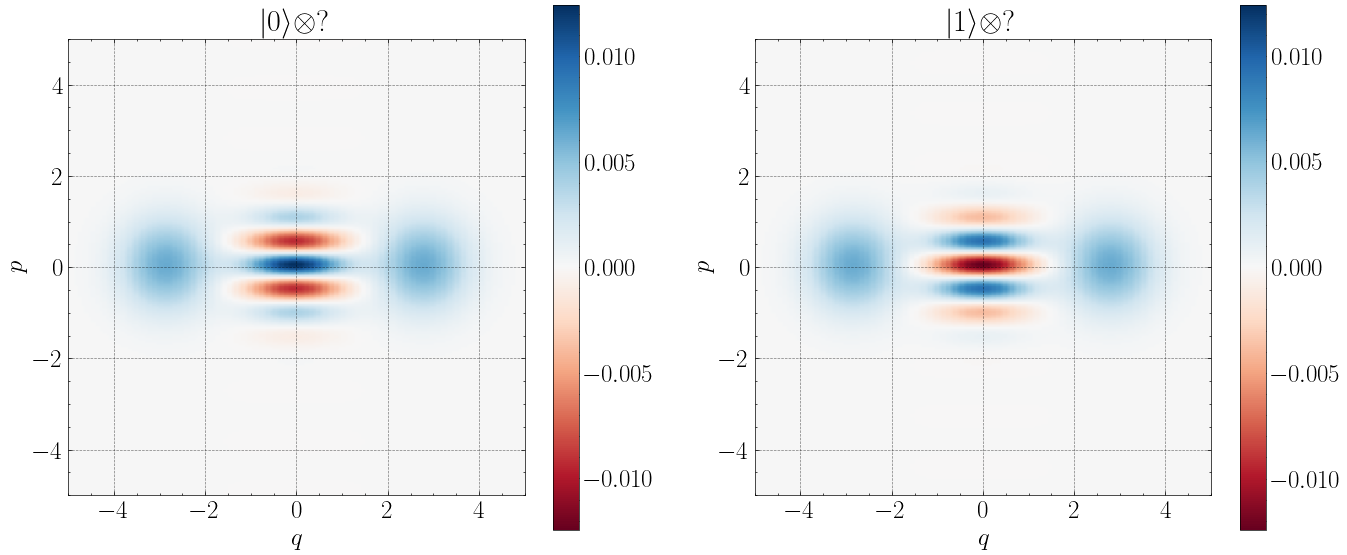

In [15]:
# Test Rotation Gate
sim.rotation(1, pi/4)
debugPlot()
sim.rotation(1, pi/4)
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


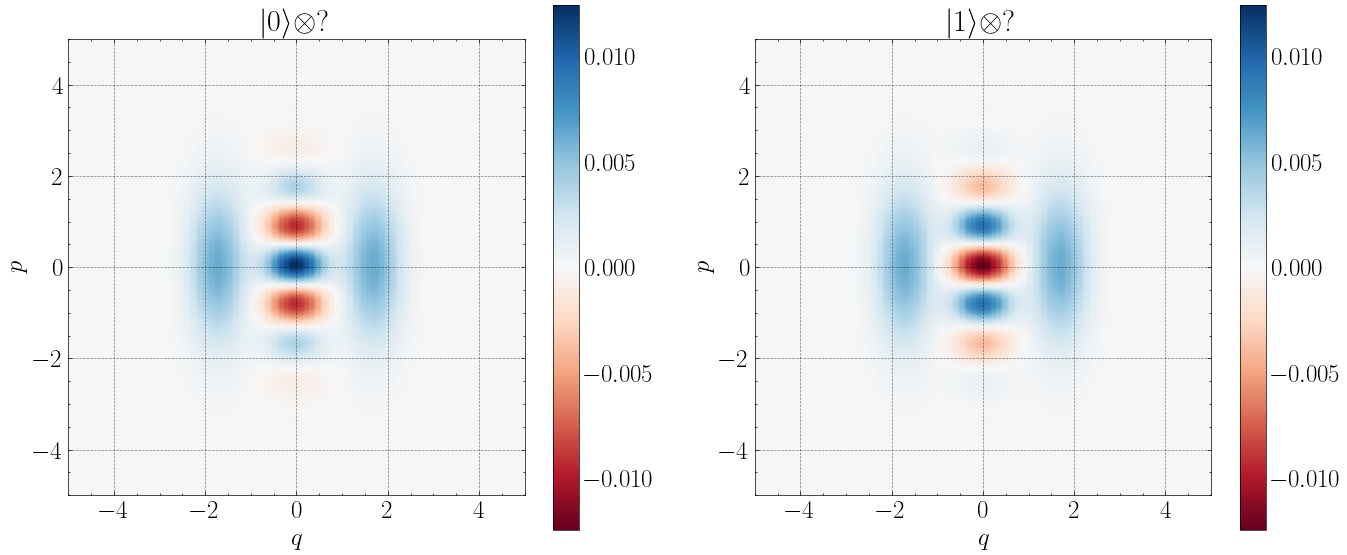

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


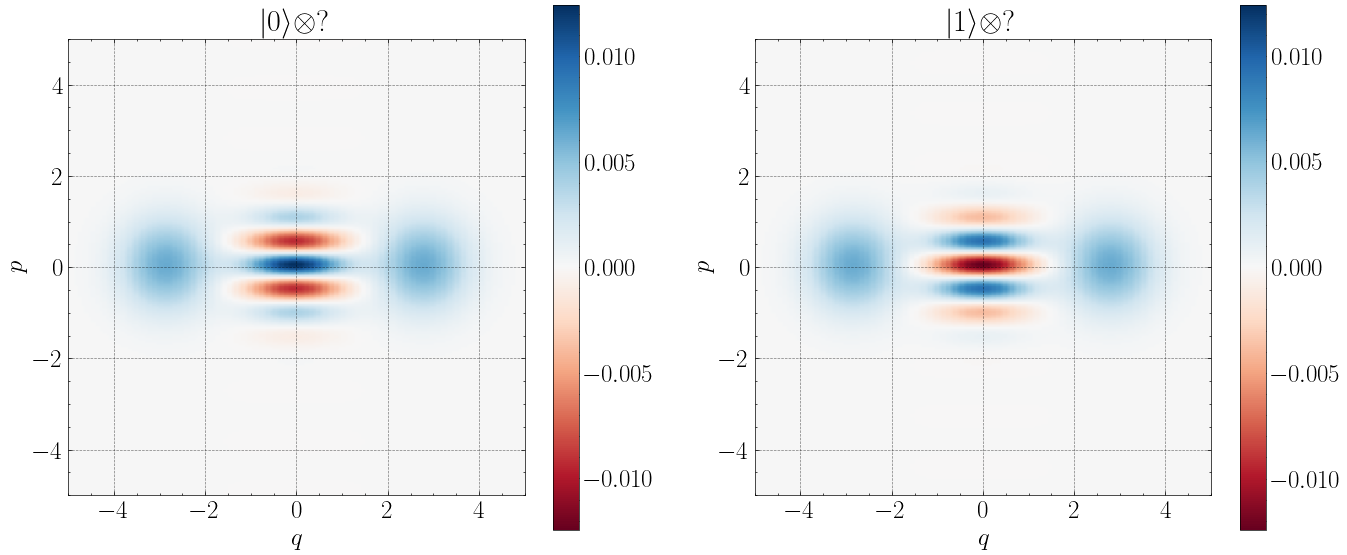

In [16]:
# Test Squeezing Gate
sim.squeezing(1, -0.5)
debugPlot()
sim.squeezing(1, 0.5)
debugPlot()

In [17]:
del sim

---
# Part 3: Beam Splitter Tests

Test beam splitter gate between two CV modes.

Number of registers: 2
Total state size: 16777216 elements (0.250 GB in VRAM)
  Register 0: dim=4096, qubits=12, dx=0.039166, x_bound=160.424210
  Register 1: dim=4096, qubits=12, dx=0.039166, x_bound=160.424210
Initialized state with 2 registers, total size: 16777216
|⟨ψ|0,4⟩|^2 = 1.000000
|⟨ψ|1,3⟩|^2 = 0.000000
|⟨ψ|2,2⟩|^2 = 0.000000
|⟨ψ|3,1⟩|^2 = 0.000000
|⟨ψ|4,0⟩|^2 = 0.000000


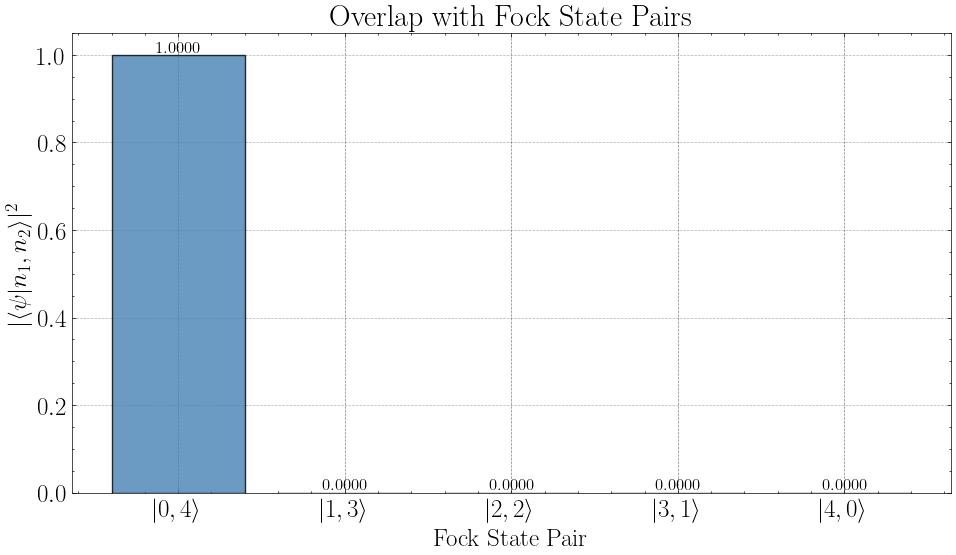

In [18]:
CV_LEVEL_1 = 12
CV_LEVEL_2 = 12
sim = CVDV([CV_LEVEL_1, CV_LEVEL_2])

# Initialize: |0,4⟩ (first mode in Fock 0, second mode in Fock 4)
sim.setFock(0, 0)
sim.setFock(1, 4)
sim.initStateVector()
sim.info()

def debugPlot():
    """Plot inner products with Fock state pairs |n1,n2⟩ where n1+n2=4."""
    # Fock state pairs to test: |0,4⟩, |1,3⟩, |2,2⟩, |3,1⟩, |4,0⟩
    fock_pairs = [(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]
    overlap = []
    labels = []
    
    for n1, n2 in fock_pairs:
        # Set register arrays to the Fock state pair
        sim.setFock(0, n1)
        sim.setFock(1, n2)
        
        # Compute inner product with current state
        overlap_val = sim.innerProduct()
        overlap.append(abs(overlap_val)**2)
        labels.append(f'$|{n1},{n2}\\rangle$')
        
        print(f"|⟨ψ|{n1},{n2}⟩|^2 = {abs(overlap_val)**2:.6f}")
    
    # Plot bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(labels)), overlap, color='steelblue', alpha=0.8, edgecolor='black')
    ax.set_xlabel('Fock State Pair')
    ax.set_ylabel(r'$|\langle\psi|n_1,n_2\rangle|^2$')
    ax.set_title('Overlap with Fock State Pairs')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, overlap)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()

debugPlot()


## Test: Beam Splitter BS(π/2)

Apply 50:50 beam splitter (θ=π/2) twice.

|⟨ψ|0,4⟩|^2 = 0.062430
|⟨ψ|1,3⟩|^2 = 0.249719
|⟨ψ|2,2⟩|^2 = 0.374579
|⟨ψ|3,1⟩|^2 = 0.249719
|⟨ψ|4,0⟩|^2 = 0.062430


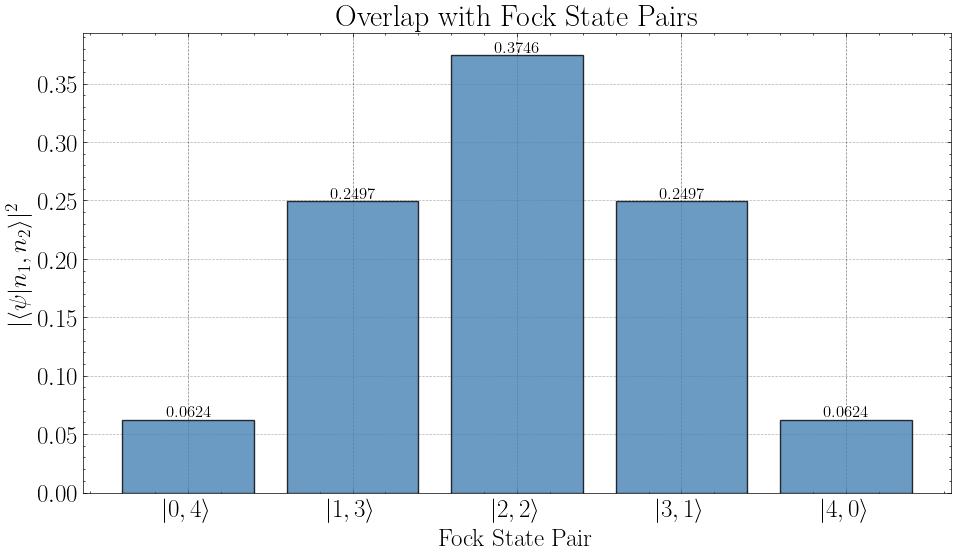

In [19]:
# Apply 50:50 beam splitter (θ = π/2)
sim.beamSplitter(0, 1, pi/2)
debugPlot()

|⟨ψ|0,4⟩|^2 = 0.000000
|⟨ψ|1,3⟩|^2 = 0.000000
|⟨ψ|2,2⟩|^2 = 0.000000
|⟨ψ|3,1⟩|^2 = 0.000001
|⟨ψ|4,0⟩|^2 = 0.996171


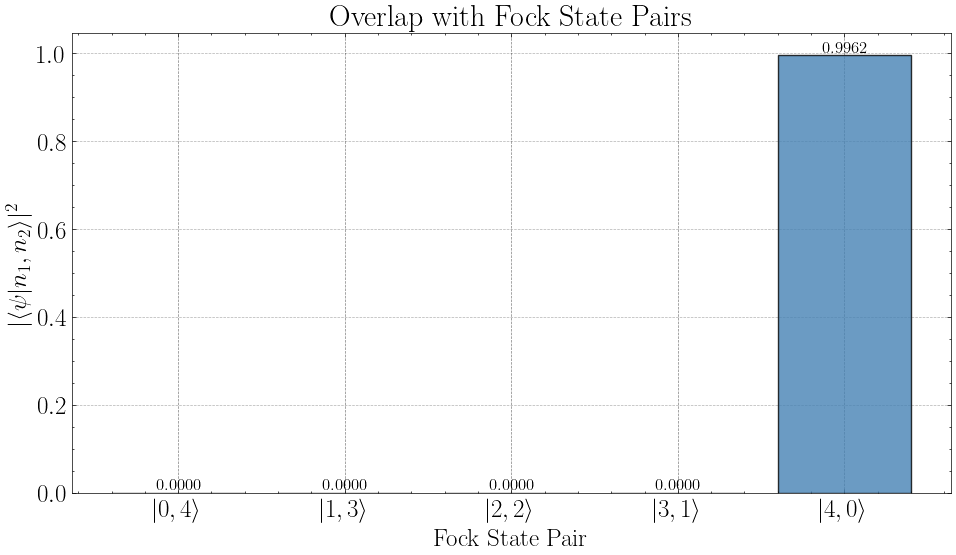

In [20]:
# Apply beam splitter again
sim.beamSplitter(0, 1, pi/2)
debugPlot()